## **Task: Quarks and Gluons**
The goal is to build a classification model that can distinguish between quark(1) and gluon(0) jets based on the following features for particles in various jetstreams:
1. p_T​ (transverse momentum of the particle)
2. Rapidity
3. Azimuthal angle (ϕ)
4. PDG ID (identifies the type of particle)

After data preprocessing (wherever applicable) and implementing various classification models, I aim to compare their efficiency and accuracies in order to reach to the best one for this PS.




In [2]:
import numpy as np
import pandas as pd
!pip install energyflow
import energyflow

from google.colab import drive
drive.mount('/content/drive')

file_path="/content/drive/MyDrive/QG_jets.npz"
data = np.load(file_path)

X = data['X']
y = data['y']

Mounted at /content/drive


### Exploratory Data Analysis

In [32]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

first_jet = X[0]  # First jet's data

# Converting it to a DataFrame for better transparency and ease of use
first_jet_df = pd.DataFrame(first_jet, columns=["p_T", "Rapidity", "Azimuthal Angle (ϕ)", "PDG ID"])

print("First jet data (for the first 139 particles):")
print(first_jet_df.head())  # Displaying the first few particles of the first jet

print(first_jet_df.describe()) #Statistical measures

Shape of X: (100000, 139, 4)
Shape of y: (100000,)
First jet data (for the first 139 particles):
        p_T  Rapidity  Azimuthal Angle (ϕ)  PDG ID
0  0.268769  0.356903             4.741387    22.0
1  0.160076 -0.255610             4.550229    22.0
2  1.148687 -0.062438             4.503854  -211.0
3  4.131591  0.173686             4.766224  -321.0
4  1.695997 -0.212178             4.796872  -211.0
              p_T    Rapidity  Azimuthal Angle (ϕ)      PDG ID
count  139.000000  139.000000           139.000000  139.000000
mean     3.603002   -0.002295             0.610588   -1.136691
std     28.870513    0.045954             1.589093   53.146939
min      0.000000   -0.255610             0.000000 -321.000000
25%      0.000000    0.000000             0.000000    0.000000
50%      0.000000    0.000000             0.000000    0.000000
75%      0.000000    0.000000             0.000000    0.000000
max    335.399046    0.356903             4.796872  321.000000


p_T                    0
Rapidity               0
Azimuthal Angle (ϕ)    0
PDG ID                 0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   p_T                  139 non-null    float64
 1   Rapidity             139 non-null    float64
 2   Azimuthal Angle (ϕ)  139 non-null    float64
 3   PDG ID               139 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


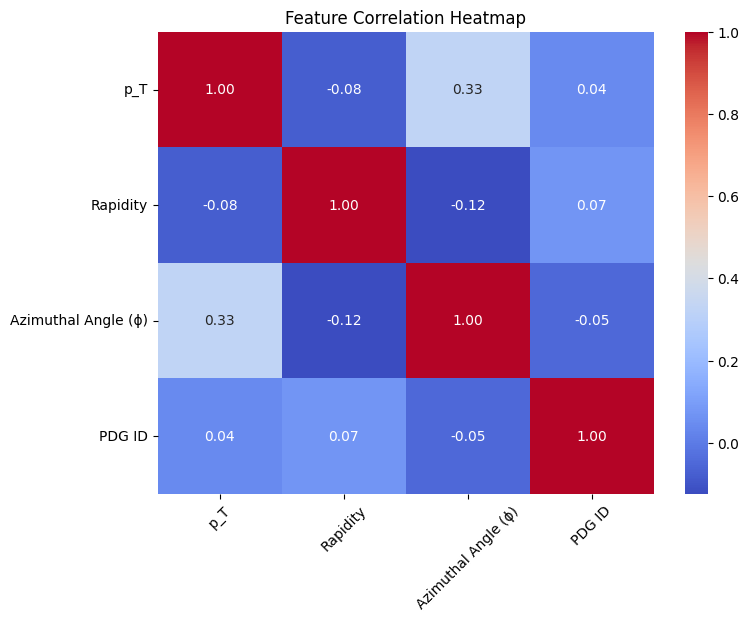

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
print(first_jet_df.isnull().sum())
first_jet_df.info()

#generating a heatmap in order to get an idea of the correlation of features
correlation_matrix = first_jet_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

The heatmap shows that there is very little correlation betweeen the features or that they are largely independent.

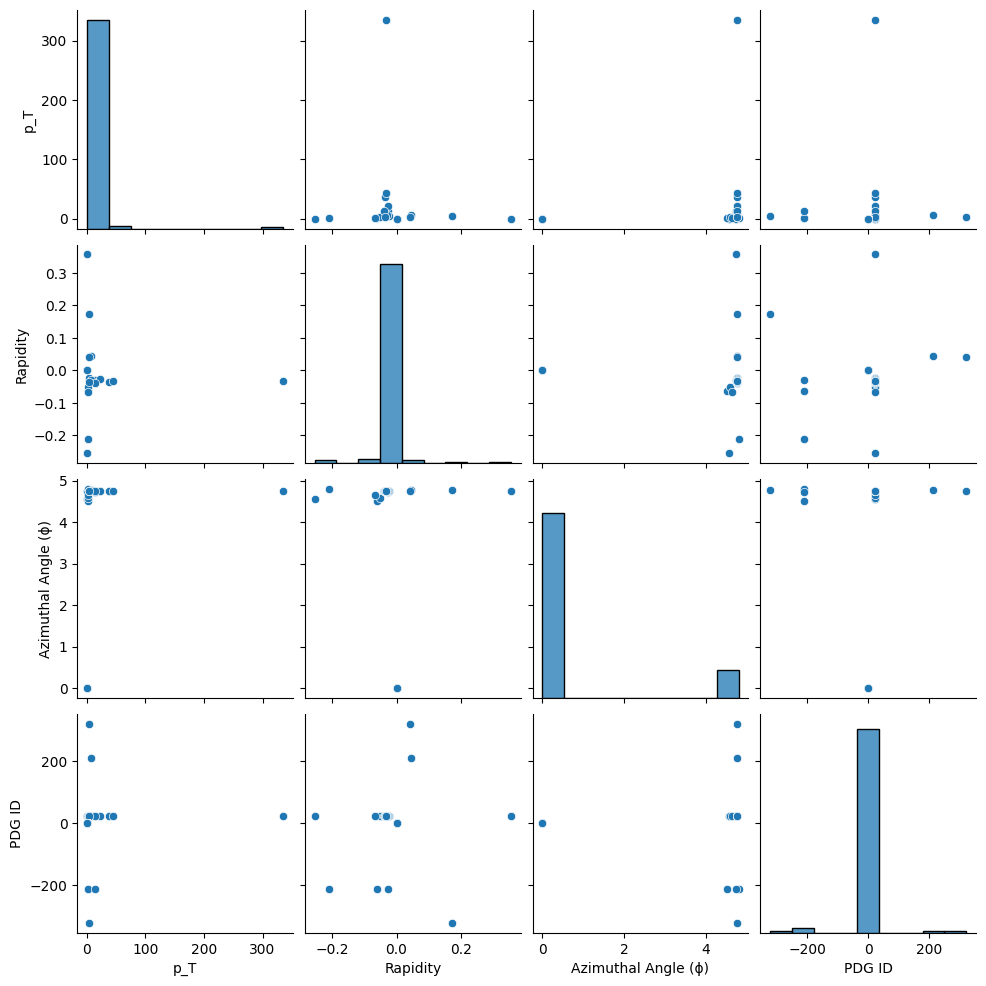

In [34]:
#displaying pairplots
import seaborn as sns
sns.pairplot(data=first_jet_df)
plt.show()

The pairplots show the existence of certain outliers that can be checked by evaluating the Z-scores and filtering outliers.

In [35]:
import pandas as pd
from scipy.stats import zscore

# Calculating Z-scores
z_scores = first_jet_df[['p_T', 'Rapidity', 'Azimuthal Angle (ϕ)']].apply(zscore)

# Identifying and filtering rows with Z-scores greater than 3 or less than -3
outliers_zscore = (z_scores > 3) | (z_scores < -3)
df_no_outliers = first_jet_df[~outliers_zscore.any(axis=1)]

# Display the cleaned dataset
print(df_no_outliers)


          p_T  Rapidity  Azimuthal Angle (ϕ)  PDG ID
2    1.148687 -0.062438             4.503854  -211.0
5    2.193726 -0.052478             4.575596    22.0
6    1.619097 -0.067625             4.645612    22.0
7    6.592149  0.044269             4.765971   211.0
8    3.770963  0.042248             4.754732   321.0
..        ...       ...                  ...     ...
134  0.000000  0.000000             0.000000     0.0
135  0.000000  0.000000             0.000000     0.0
136  0.000000  0.000000             0.000000     0.0
137  0.000000  0.000000             0.000000     0.0
138  0.000000  0.000000             0.000000     0.0

[134 rows x 4 columns]


Implementing Random Forest Classifier

In [39]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Reshaping X to have one feature vector per jet by flattening the particles' features
X_reshaped = X.reshape(X.shape[0], -1)

# Shuffle the data for randomness
X, y = shuffle(X_reshaped, y, random_state=42)

X_train_sub, _, y_train_sub, _ = train_test_split(X, y, test_size=0.9, random_state=42)
# Using a small subset of the 1,00,000 paricles in a jet for faster experimentation

X_train, X_test, y_train, y_test = train_test_split(X_train_sub, y_train_sub, test_size=0.2, random_state=42)

# Standardizing the features to prevent any discrepancies
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')


### Hyperparameter Tuning and Results

Best hyperparameters found: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Accuracy of optimized model: 0.7695
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78      1016
         1.0       0.79      0.72      0.75       984

    accuracy                           0.77      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.77      0.77      0.77      2000



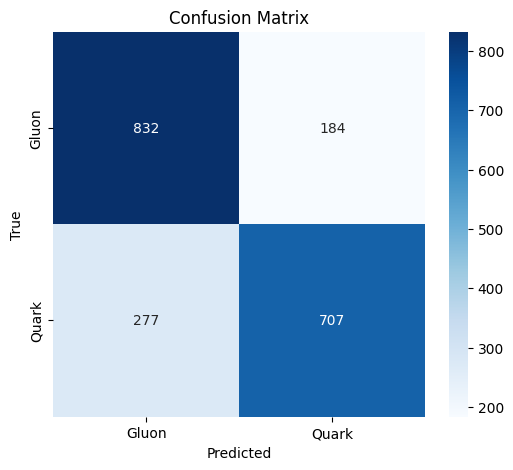

In [40]:
# Implementing RandomSearch
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, random_state=42, n_jobs=-1, cv=3)
random_search.fit(X_train_scaled, y_train)

print("Best hyperparameters found:", random_search.best_params_)

y_pred = random_search.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of optimized model: {accuracy:.4f}")

# more evaluation metrics
print(classification_report(y_test, y_pred))
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gluon', 'Quark'], yticklabels=['Gluon', 'Quark'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()